# Week 5: Image Histograms


In [1]:
import numpy as np
import copy
import cv2
from matplotlib import pyplot as plt
import random
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('default')
plt.style.use('fivethirtyeight')

## Task 1: Compute Histogram
Histograms can be rather important when it comes to adjusting the brightness of an image.
Your first task is to compute a histogram of an image of your choice and display this as a plot.

*Note: Do not use Matlab’s imhist function*

In [2]:
def compute_hist(img):
    '''
    Impelemnt 
    :param img: gray scaled image with size HxW
    :return h: image histogram
    '''
    r,c = img.shape
    h = np.zeros((256,1))
    # write your code here
    for i in range(r):
        for j in range(c):
            h[img[i, j]] += 1
    return h

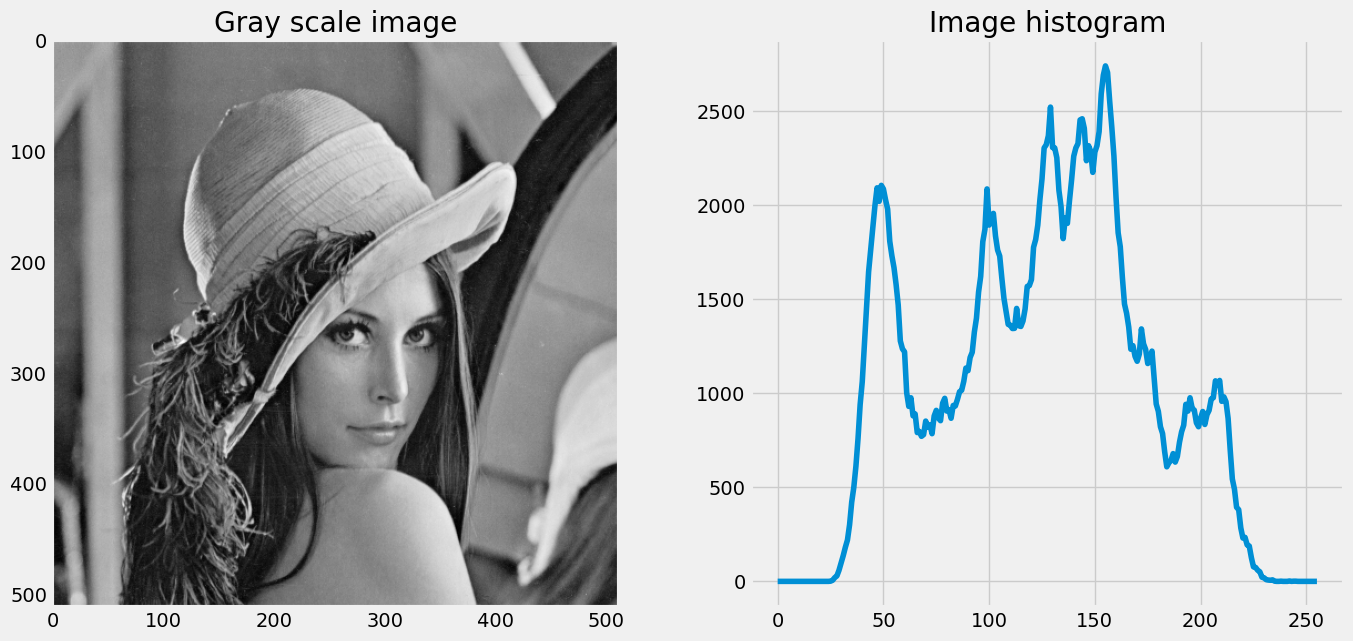

In [3]:
img = cv2.imread('../images/Lenna.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_hist = compute_hist(gray_img)

# Show Original and segmented image
fig, axis = plt.subplots(1, 2, figsize=(15,7), sharey=False)
#fig.subplots_adjust(wspace=-0.2, hspace=0.0)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')

axis[1].plot(img_hist)
axis[1].set_title('Image histogram')

plt.show()

## Task 2: Histogram Equalisation
Histogram Equalisation is often used to adjust the global contrast of an image.
It is most useful when an image’s background is either too dark or too light and can bring out more detail in under exposed images.

We can calculate this by:
$$
    h(v) = \frac{cdf(v) - cdf_{min}}{(M \times N) - cdf_{min}}x(L - 1)
$$

Where $v$ is the current value to be adjusted, $(M \times N)$ is the size of the image and $L$ is the number of intensity levels i.e. 256.
The cdf is the cumulative distribution of the histogram.

Your task would be to calculate the new mappings, apply this to the image and plot the new
equalised histogram. As shown below:

In [4]:
def hist_equalisation(img, img_hist, L=256):
    '''
    Impelemnt 
    :param img: gray scaled image with size HxW
    :param img_hist: histogram of the input image
    :param L: the number of intensity levels
    :return: eqalized image  of size HxW
    '''
    m,n = img.shape
    # write your code here
    eqImg = np.zeros_like(img)
    
    #For a specific pixel value, CDF represents the ratio of the number of pixels less than or equal to 
    #this pixel value to all pixels in the image.
    cdf = img_hist.cumsum()
    cdf_min = cdf.min()
    h = (cdf - cdf_min) / (m * n - cdf_min) * (L - 1)
    
    for i in range(m):
        for j in range(n):
            eqImg[i, j] = h[img[i, j]]
    assert eqImg.shape == img.shape, f'wrong image shape your transformation shouldn\'t change image dimensions, expected {img.shape}, we got {eqImg.shape}'
    return eqImg

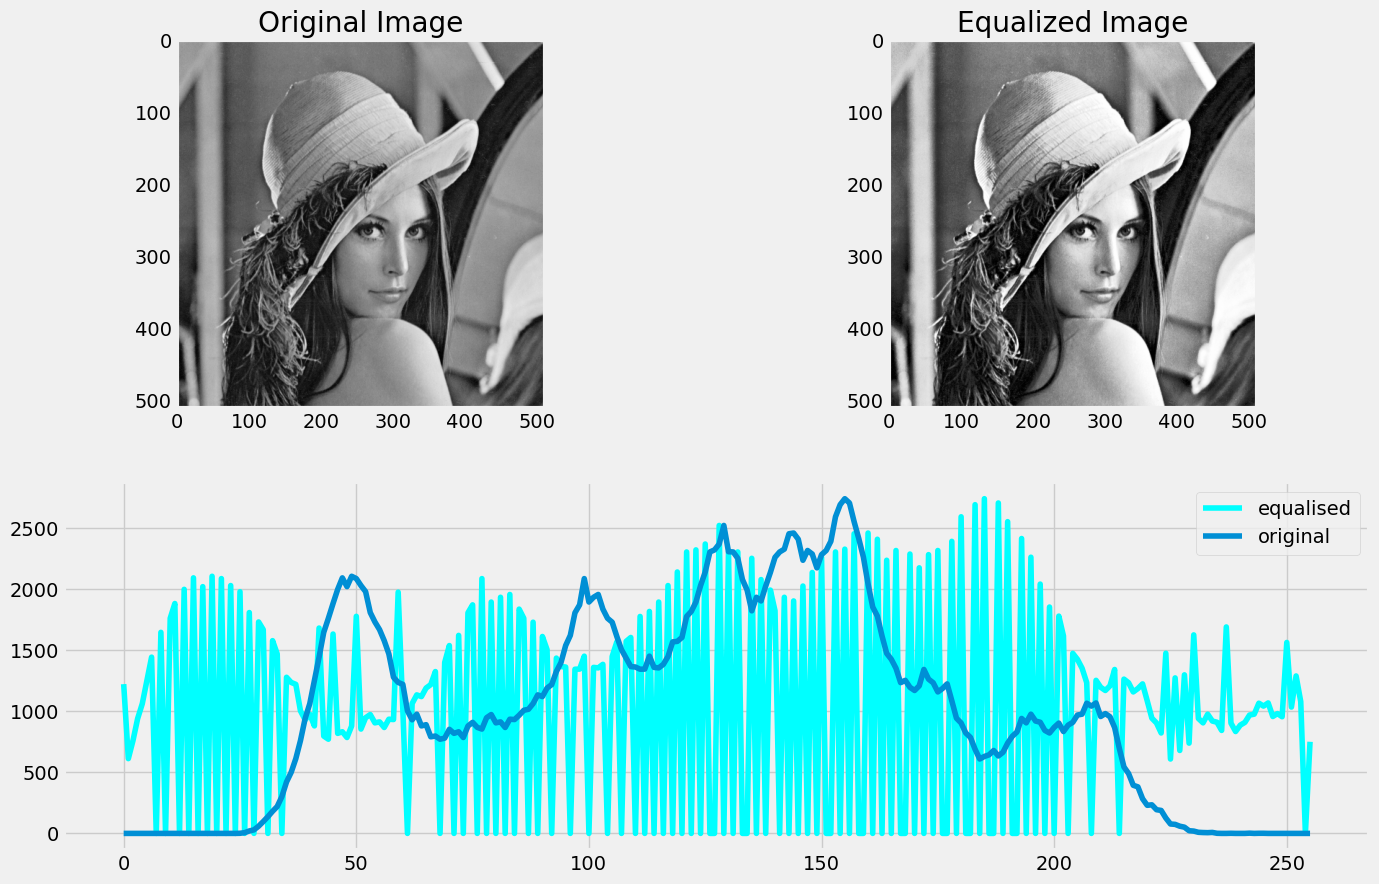

In [5]:
eqImg = hist_equalisation(gray_img, img_hist, L=256)
eqImg_hist = compute_hist(eqImg.astype(int)-1)

# Plot Original and Equalised image
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.imshow(gray_img, 'gray')
plt.grid(False)
plt.title('Original Image')

plt.subplot(222)
plt.imshow(eqImg, 'gray')
plt.grid(False)
plt.title('Equalized Image')

plt.subplot(212)
plt.plot(eqImg_hist, color='cyan', label='equalised')
plt.plot(img_hist, label='original')
plt.legend()

plt.show()

## Task 3: Histogram Matching

Your next task is to be able to adjust an image based on the histogram of another.
This is done using histogram equalisation and can be helpful if you would like to adjust a series of images with different
global illuminations.

One example of how this could be used is if you captured a series of images of a friend standing on the Tower of London.
When looking at the pictures the only one where your friend had their eyes open was when a cloud was covering the sun.
Using histogram matching you could adjust this image’s brightness (and contrast) to match the other better illuminated images.

To perform histogram matching we need to first calculate the normalised CDF of the source image and the target image, cdfSource and cdfTarget.

The normalised CDF for each image is obtained by dividing the value in each bin of the original CDF with the maximum value of the original CDF (last bin of the original CDF), so we get a value between 0 and 1 in each bin of the normalised CDF.

We then need to find a mapping function F that maps cdfSource to cdfTarget.
This mapping function can then be applied to the input image.
The mapping function needed is quite simple and can be obtained by comparing the values between cdfSource and cdfTarget.
We would like to map cdfSource (valueS) to cdfTarget (valueT) for each valueS in [0,255] to obtain valueOut in [0,255].
One way to do this, is to find the first cdfSource (valueS) that is greater than cdfTarget(valueT), and that valueT will be the mapping F(valueS) à valueOut.

In [34]:
def hist_match(source_img, target_img):
    '''
    Impelemnt 
    :param source_img: gray scaled source image to be changed with size HxW
    :param target_img: gray scaled target image to be macthed with size HxW
    :return out_img: The transformed output image 
    :return src_hist: source image histogram
    :return tag_hist: target image histogram
    '''
    m,n = source_img.shape
    # write your code here
    src_hist = np.zeros((256,1))
    src_hist = compute_hist(source_img)
    tag_hist = np.zeros((256,1))
    tag_hist = compute_hist(target_img)
    
    src_cdf = src_hist.cumsum()
    src_cdf_max = src_cdf.max()
    src_cdf_norm =  src_cdf / src_cdf_max
    tag_cdf = tag_hist.cumsum()
    tag_cdf_max = tag_cdf.max()
    tag_cdf_norm =  tag_cdf / tag_cdf_max
    
    mapping = np.zeros(256)
    temp = 0
    for i in range(256):
        while temp < 256 and tag_cdf_norm[temp] < src_cdf_norm[i]:
            temp += 1
        mapping[i] = temp
        
    # out_img = np.zeros_like(img)
    # w, h, c = img.shape
    # for ch in range(c):
    #     out_img[:, :, ch] = mapping[img[:, :, ch]]
    out_img = mapping[source_img]
    
    #assert out_img.shape == img.shape, f'wrong image shape your transformation shouldn\'t change image dimensions, expected {img.shape}, we got {eqImg.shape}'
    
    return out_img, src_hist, tag_hist

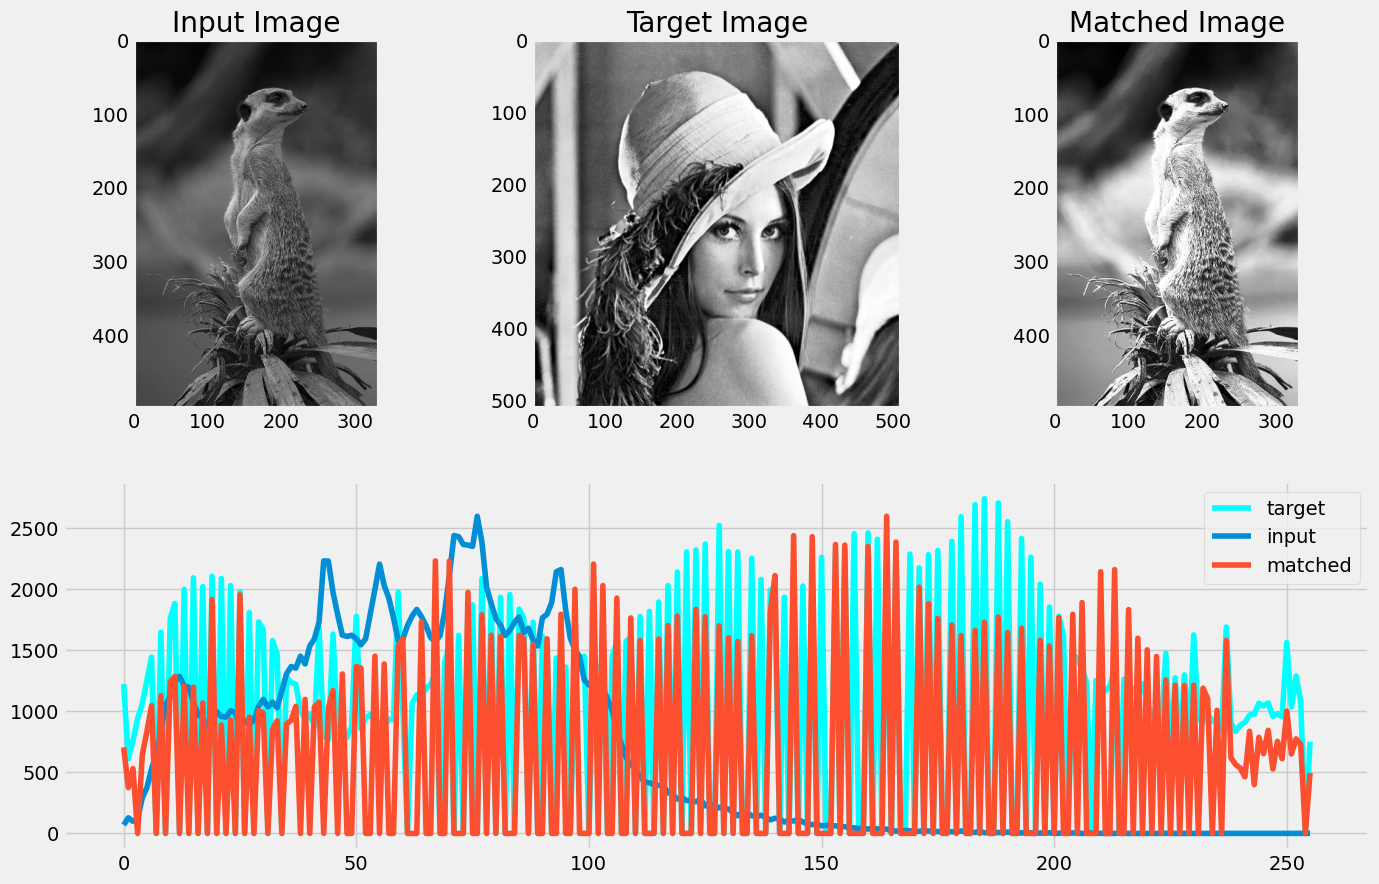

In [35]:
src_img = cv2.imread('../images/meerkat.jpg')
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

matched_img, src_hist, tag_hist = hist_match(src_img, eqImg.astype(int) - 1)
matched_hist = compute_hist(matched_img.astype(int))

#matched_img = hist_match(src_img, eqImg.astype(int) - 1)

# Plot Input, Output and Matched image
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(src_img, 'gray')
plt.grid(False)
plt.title('Input Image')

plt.subplot(232)
plt.imshow(eqImg, 'gray')
plt.grid(False)
plt.title('Target Image')

plt.subplot(233)
plt.imshow(matched_img, 'gray')
plt.grid(False)
plt.title('Matched Image')

plt.subplot(212)
plt.plot(eqImg_hist, color='cyan', label='target')
plt.plot(src_hist, label='input')
plt.plot(matched_hist, label='matched')
plt.legend()

plt.show()

## Task 4: Image Transformations
Your last task is rather simple and just requires you to run an example.
The idea is just to show you a beneficial use of applying affine or perspective transformations to images and how this could be used in practice.
But we advice you to take a look at the code in utils.

In [35]:
tag_img = cv2.imread('../images/plate_side.jpg')
tag_img = cv2.cvtColor(tag_img, cv2.COLOR_BGR2GRAY)

ref_img = cv2.imread('../images/reference.jpg')
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)

In [38]:
# stop inline plot so we can select points
%matplotlib

# Locate points of the documents or object which you want to transform into
plt.imshow(ref_img, 'gray')
ref_pts = plt.ginput(4)

In [39]:
# Locate points of the documents or object which you want to transform
plt.imshow(tag_img, 'gray')
tag_pts = plt.ginput(4)

In [41]:
# switch to inline plot and we can see plots in the notebook
%matplotlib inline
from utils import four_point_transform

warped = four_point_transform(tag_img, np.float32(tag_pts))

# Plot Input, Output and Matched image
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(warped, 'gray')
plt.grid(False)
plt.title('Transformed Image')

plt.show()

Try playing with the next code it should give the same result, consider changing the szie and points so that you have better image.

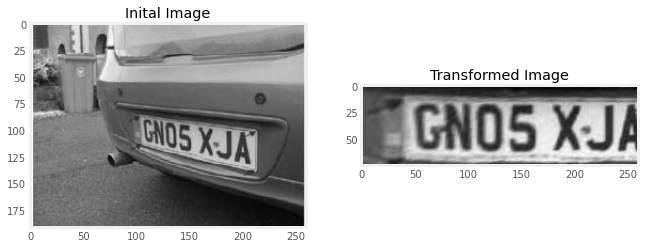

In [193]:
# switch to inline plot and we can see plots in the notebook
%matplotlib inline

# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(np.float32(tag_pts), np.float32(ref_pts))
result = cv2.warpPerspective(tag_img, matrix, (260,75))
# Wrap the transformed image

# Plot Input, Output and Matched image
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(tag_img, 'gray')
plt.grid(False)
plt.title('Inital Image')

plt.subplot(232)
plt.imshow(result, 'gray')
plt.grid(False)
plt.title('Transformed Image')

plt.show()

### Histogram

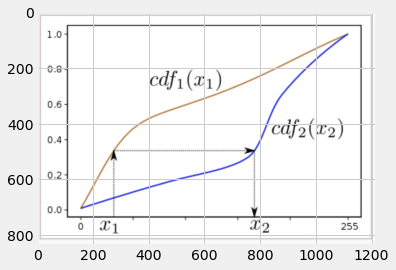

In [2]:
hist = cv2.imread('../images/histogram-cdf.png')
plt.imshow(hist)